In [153]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.v2 import ToImage, ToDtype, RandomAffine
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 

In [154]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

True
NVIDIA GeForce RTX 4060


In [155]:
data_aug = transforms.Compose([
    ToImage(),
    RandomAffine(
        degrees=10,
        translate=(0.15, 0.15),
        scale=(0.8, 1.1),
        shear=10
    ),
    ToDtype(torch.float32, scale=True)
])

test_transforms = transforms.Compose([
    ToImage(),
    ToDtype(torch.float32, scale=True)
])

trainD = datasets.MNIST(root="data", train=True, download=True, transform=data_aug)
testD = datasets.MNIST(root="data", train=False, download=True, transform=test_transforms)

In [156]:
BATCH_SIZE = 128
DEVICE = torch.accelerator.current_accelerator()

train_DL = DataLoader(trainD, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
test_DL = DataLoader(testD, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

for X, y in test_DL:
  print("shape x:", X.shape) # batchsize, channels, w, h
  print("shape y:", y.shape, y.dtype), # label shape of batch
  break

shape x: torch.Size([128, 1, 28, 28])
shape y: torch.Size([128]) torch.int64


In [157]:
loss_fn = nn.CrossEntropyLoss()

In [158]:
class Mnist(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.model = nn.Sequential(
      nn.Linear(28*28, 256),
      nn.ReLU(),
      nn.Dropout(0.3),

      nn.Linear(256, 256),
      nn.ReLU(),
      nn.Dropout(0.3),
      
      nn.Linear(256, 10)
    )
  
  def forward(self, X):
    X = self.flatten(X) # 28*28 images to (784, 1)
    logits = self.model(X)
    return logits

In [159]:
def accuracy(output, y):
  preds = torch.argmax(output, dim=1)
    # y (labels) == preds.argmax
  return (preds == y).float().mean()*100

In [160]:
def train(dataloader, model, loss_fn, optimizer=None):
  model.train()
  size = len(dataloader.dataset)
  lr = 1e-3
  loss_t = []

  for batch_i, (X, y) in enumerate(dataloader): # in batches from DL
    X, y = X.to(DEVICE), y.to(DEVICE)

    pred = model(X)
    loss = loss_fn(pred, y)
    loss.backward()

    if (not optimizer):
      # -- MANUAL SGD
      with torch.no_grad():
        for param in model.parameters():
          param -= param.grad * lr # update gradients
      model.zero_grad() # reset gradients
    else:
      # optimization
      optimizer.step()
      optimizer.zero_grad() # clear gradients

    if (batch_i) % 100 < 1:
      loss_t.append(loss.item())
      print(f"Curr: {batch_i*BATCH_SIZE + len(X)}/{size}, Loss = {loss.item():.4f}")
    


In [161]:
def testing(dataloader, model, loss_fn):
  model.eval()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss = correct = 0

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(DEVICE), y.to(DEVICE)

      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(dim=1) == y).type(torch.float).sum().item()

  avg_loss = test_loss / num_batches
  accuracy = correct / size

  print("Test completed,")
  print(f"Accuracy: {accuracy*100:.2f}%, Avg Loss: {avg_loss:.4f}\n")

  return accuracy, avg_loss

In [162]:
def fit(epochs: int):
  model = Mnist().to(DEVICE)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  acc = []
  loss = []

  print("Starting!")
  for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    train(train_DL, model, loss_fn, optimizer)
    epoch_acc, epoch_loss = testing(test_DL, model, loss_fn)
    acc.append(round(epoch_acc*100))
    loss.append(epoch_loss)
    
  print("Done!")

  torch.save(model.state_dict(), "mnist_weights.pth")
  print("Weights saved to `mnist_weights.pth`")
  return acc, loss

Starting!
Epoch 1
Curr: 128/60000, Loss = 2.3057
Curr: 12928/60000, Loss = 1.3017
Curr: 25728/60000, Loss = 1.0682
Curr: 38528/60000, Loss = 0.9987
Curr: 51328/60000, Loss = 0.6950
Test completed,
Accuracy: 91.90%, Avg Loss: 0.2755

Epoch 2
Curr: 128/60000, Loss = 0.5656
Curr: 12928/60000, Loss = 0.6358
Curr: 25728/60000, Loss = 0.5386
Curr: 38528/60000, Loss = 0.4882
Curr: 51328/60000, Loss = 0.4548
Test completed,
Accuracy: 94.89%, Avg Loss: 0.1794

Epoch 3
Curr: 128/60000, Loss = 0.2819
Curr: 12928/60000, Loss = 0.3575
Curr: 25728/60000, Loss = 0.4845
Curr: 38528/60000, Loss = 0.4281
Curr: 51328/60000, Loss = 0.4768
Test completed,
Accuracy: 95.69%, Avg Loss: 0.1438

Epoch 4
Curr: 128/60000, Loss = 0.4331
Curr: 12928/60000, Loss = 0.3388
Curr: 25728/60000, Loss = 0.3688
Curr: 38528/60000, Loss = 0.5179
Curr: 51328/60000, Loss = 0.2992
Test completed,
Accuracy: 96.13%, Avg Loss: 0.1304

Epoch 5
Curr: 128/60000, Loss = 0.3433
Curr: 12928/60000, Loss = 0.4239
Curr: 25728/60000, Loss = 

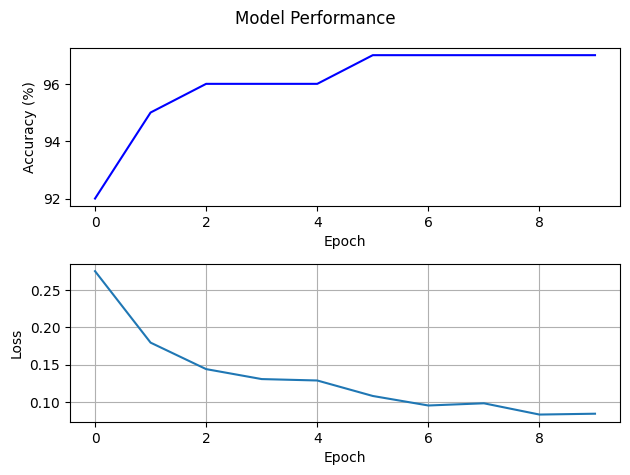

In [163]:
EPOCHS = 10

acc, loss = fit(EPOCHS)
plt.subplot(211)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.plot(acc, color="blue")

plt.subplot(212)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss, label="red")

plt.suptitle("Model Performance")
plt.grid()
plt.tight_layout()
plt.savefig("performance.png")
plt.show()

In [164]:
def confusion_test():
  model = Mnist().to(DEVICE)
  dataloader = test_DL
  model.eval()
  y_true, y_pred = [], []

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(DEVICE), y.to(DEVICE)
      preds = model(X)
      
      y_true += y.cpu().numpy().astype(int).tolist()
      pred_labels = preds.argmax(dim=1)
      y_pred += pred_labels.cpu().numpy().astype(int).tolist()

  cm = confusion_matrix(y_true, y_pred, normalize='all')

  ConfusionMatrixDisplay(cm).plot(values_format=".2f")
  plt.savefig("confusion_matrix.png")
  print("Confusion matrix saved")

Confusion matrix saved


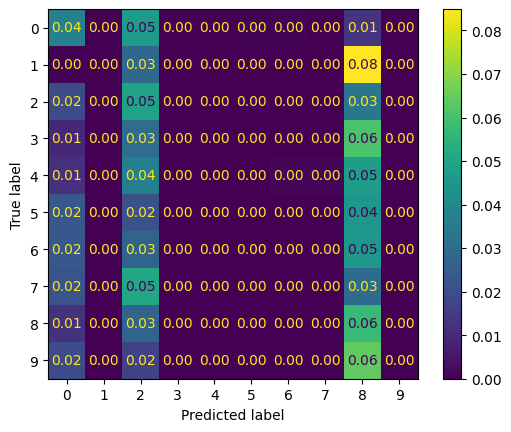

In [165]:
confusion_test()